<img src="images/dask_horizontal.svg" align="right" width="30%">

# Dask Array


<img src="images/Dask Array (Light).png" width="50%" align="right">
Dask array provides a parallel, larger-than-memory, n-dimensional array using blocked algorithms. Simply put: distributed Numpy.

*  **Parallel**: Uses all of the cores on your computer
*  **Larger-than-memory**:  Lets you work on datasets that are larger than your available memory by breaking up your array into many small pieces, operating on those pieces in an order that minimizes the memory footprint of your computation, and effectively streaming data from disk.
*  **Blocked Algorithms**:  Perform large computations by performing many smaller computations


## Learning Objectives

- Understand key features of dask arrays
- Work with Dask Array's in much the same way you would work with a NumPy array

## Prerequisites


| Concepts | Importance | Notes |
| --- | --- | --- |
| Familiarity with NumPy | Necessary | |


- **Time to learn**: *20-25 minutes*


## Setup


In [1]:
from dask.distributed import Client, LocalCluster

cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:57847,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://192.168.0.8:57859,Total threads: 4
Dashboard: http://192.168.0.8:57861/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:57851,


## Blocked Algorithms

A *blocked algorithm* executes on a large dataset by breaking it up into many small blocks.

For example, consider taking the sum of a billion numbers.  We might instead break up the array into 1,000 chunks, each of size 1,000,000, take the sum of each chunk, and then take the sum of the intermediate sums.

We achieve the intended result (one sum on one billion numbers) by performing many smaller results (one thousand sums on one million numbers each, followed by another sum of a thousand numbers.)

## `dask.array` contains these algorithms

`dask.array` implements a subset of the NumPy ndarray interface using blocked algorithms, cutting up the large array into many small arrays. This lets us compute on arrays larger than memory using multiple cores. We coordinate these blocked algorithms using Dask graphs. Dask Array's are also lazy, meaning that they do not evaluate until you explicitly ask for a result using the compute method.

### Create `dask.array` object

If we want to create a 3D NumPy array of random values, we do it like this:

In [2]:
import dask
import dask.array as da
import numpy as np
from distributed.utils import format_bytes

<ipython-input-2-7386074b240b>:4: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import format_bytes


In [3]:
shape = (600, 200, 200)
arr = np.random.random(shape)
arr

array([[[0.13694805, 0.65971039, 0.66619897, ..., 0.99284348,
         0.02205426, 0.7327201 ],
        [0.81697731, 0.95968333, 0.44685137, ..., 0.36153372,
         0.88272984, 0.0421403 ],
        [0.76721183, 0.74942689, 0.23768577, ..., 0.1395019 ,
         0.90978723, 0.65332233],
        ...,
        [0.02900562, 0.62569102, 0.03129225, ..., 0.59788115,
         0.45514612, 0.01545887],
        [0.75829734, 0.40490636, 0.73017964, ..., 0.18603317,
         0.45352644, 0.52809057],
        [0.43285915, 0.24950676, 0.8677972 , ..., 0.84635104,
         0.64993985, 0.4922448 ]],

       [[0.21147891, 0.71613174, 0.3745539 , ..., 0.31036801,
         0.50300402, 0.04910598],
        [0.28918078, 0.63654509, 0.4145036 , ..., 0.76712622,
         0.7073747 , 0.34347483],
        [0.26942797, 0.11923874, 0.79198104, ..., 0.3072557 ,
         0.0231458 , 0.84041426],
        ...,
        [0.3710663 , 0.9241944 , 0.86190241, ..., 0.23391177,
         0.13785714, 0.49805441],
        [0.1

In [4]:
format_bytes(arr.nbytes)

'183.11 MiB'

This array contains `~183 MB` of data

Now let's create the same array using Dask's array interface.

In [5]:
darr = da.random.random(shape, chunks=(300, 100, 200))

A chunk size to tell us how to block up our array, like `(300, 100, 200)`. 

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Specifying Chunks</p>
    There are <a href="https://docs.dask.org/en/latest/array-chunks.html">several ways to specify chunks</a>. In this tutorial, we will use a block shape.


</div>



In [6]:
darr

dask.array<random_sample, shape=(600, 200, 200), dtype=float64, chunksize=(300, 100, 200), chunktype=numpy.ndarray>

Notice that we just see a symbolic representation of the array, including its `shape`, `dtype`, and `chunksize`. No data has been generated yet. Let's visualize the constructed task graph. 

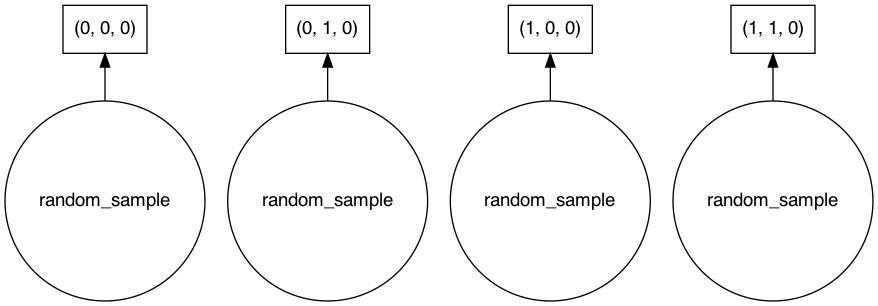

In [7]:
darr.visualize()

Our array has four chunks. To generate it, Dask calls `np.random.random` four times and then concatenates this together into one array.

### Manipulate `dask.array` object as you would a numpy array


Now that we have an `Array` we perform standard numpy-style computations like arithmetic, mathematics, slicing, reductions, etc..

The interface is familiar, but the actual work is different. `dask_array.sum()` does not do the same thing as `numpy_array.sum()`.

#### What's the difference?

`dask_array.sum()` builds an expression of the computation. It does not do the computation yet. `numpy_array.sum()` computes the sum immediately.

#### Why the difference?

Dask arrays are split into chunks. Each chunk must have computations run on that chunk explicitly. If the desired answer comes from a small slice of the entire dataset, running the computation over all data would be wasteful of CPU and memory.

In [8]:
total = darr.sum()
total

dask.array<sum-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

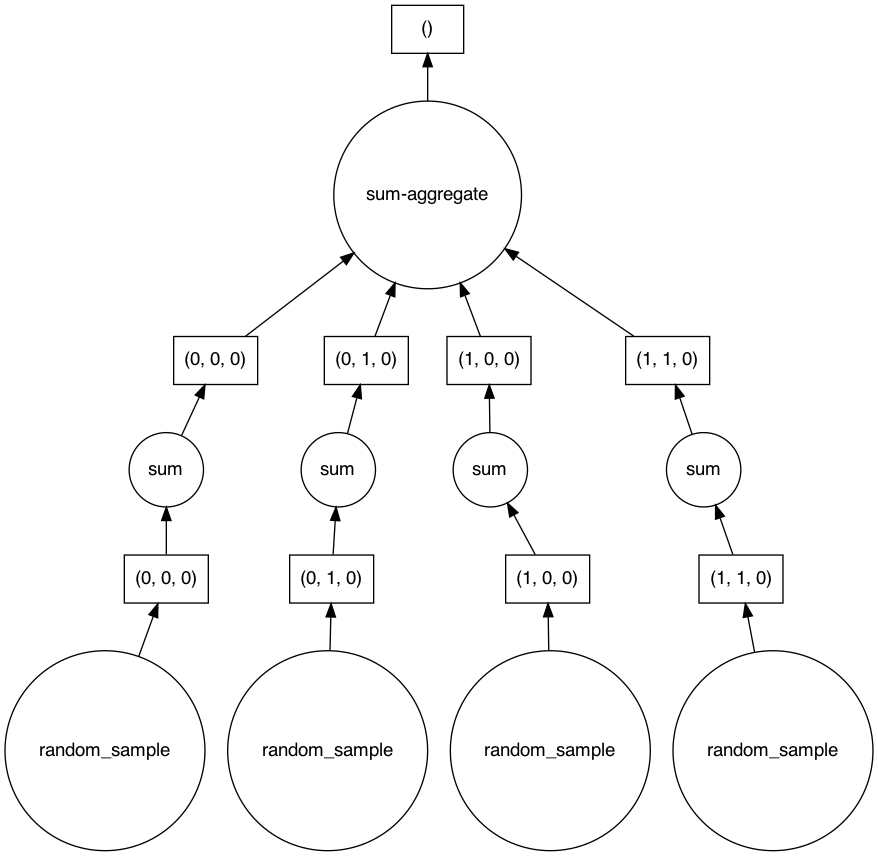

In [9]:
total.visualize()

#### Compute result

Dask.array objects are lazily evaluated.  Operations like `.sum` build up a graph of blocked tasks to execute.  

We ask for the final result with a call to `.compute()`.  This triggers the actual computation.

In [10]:
%%time
total.compute()

CPU times: user 172 ms, sys: 106 ms, total: 277 ms
Wall time: 540 ms


11998818.750294907

### Exercise: Modify the chunk size (or shape) in the random dask array, call `.sum()` on the new array, and visualize how the task graph changes.

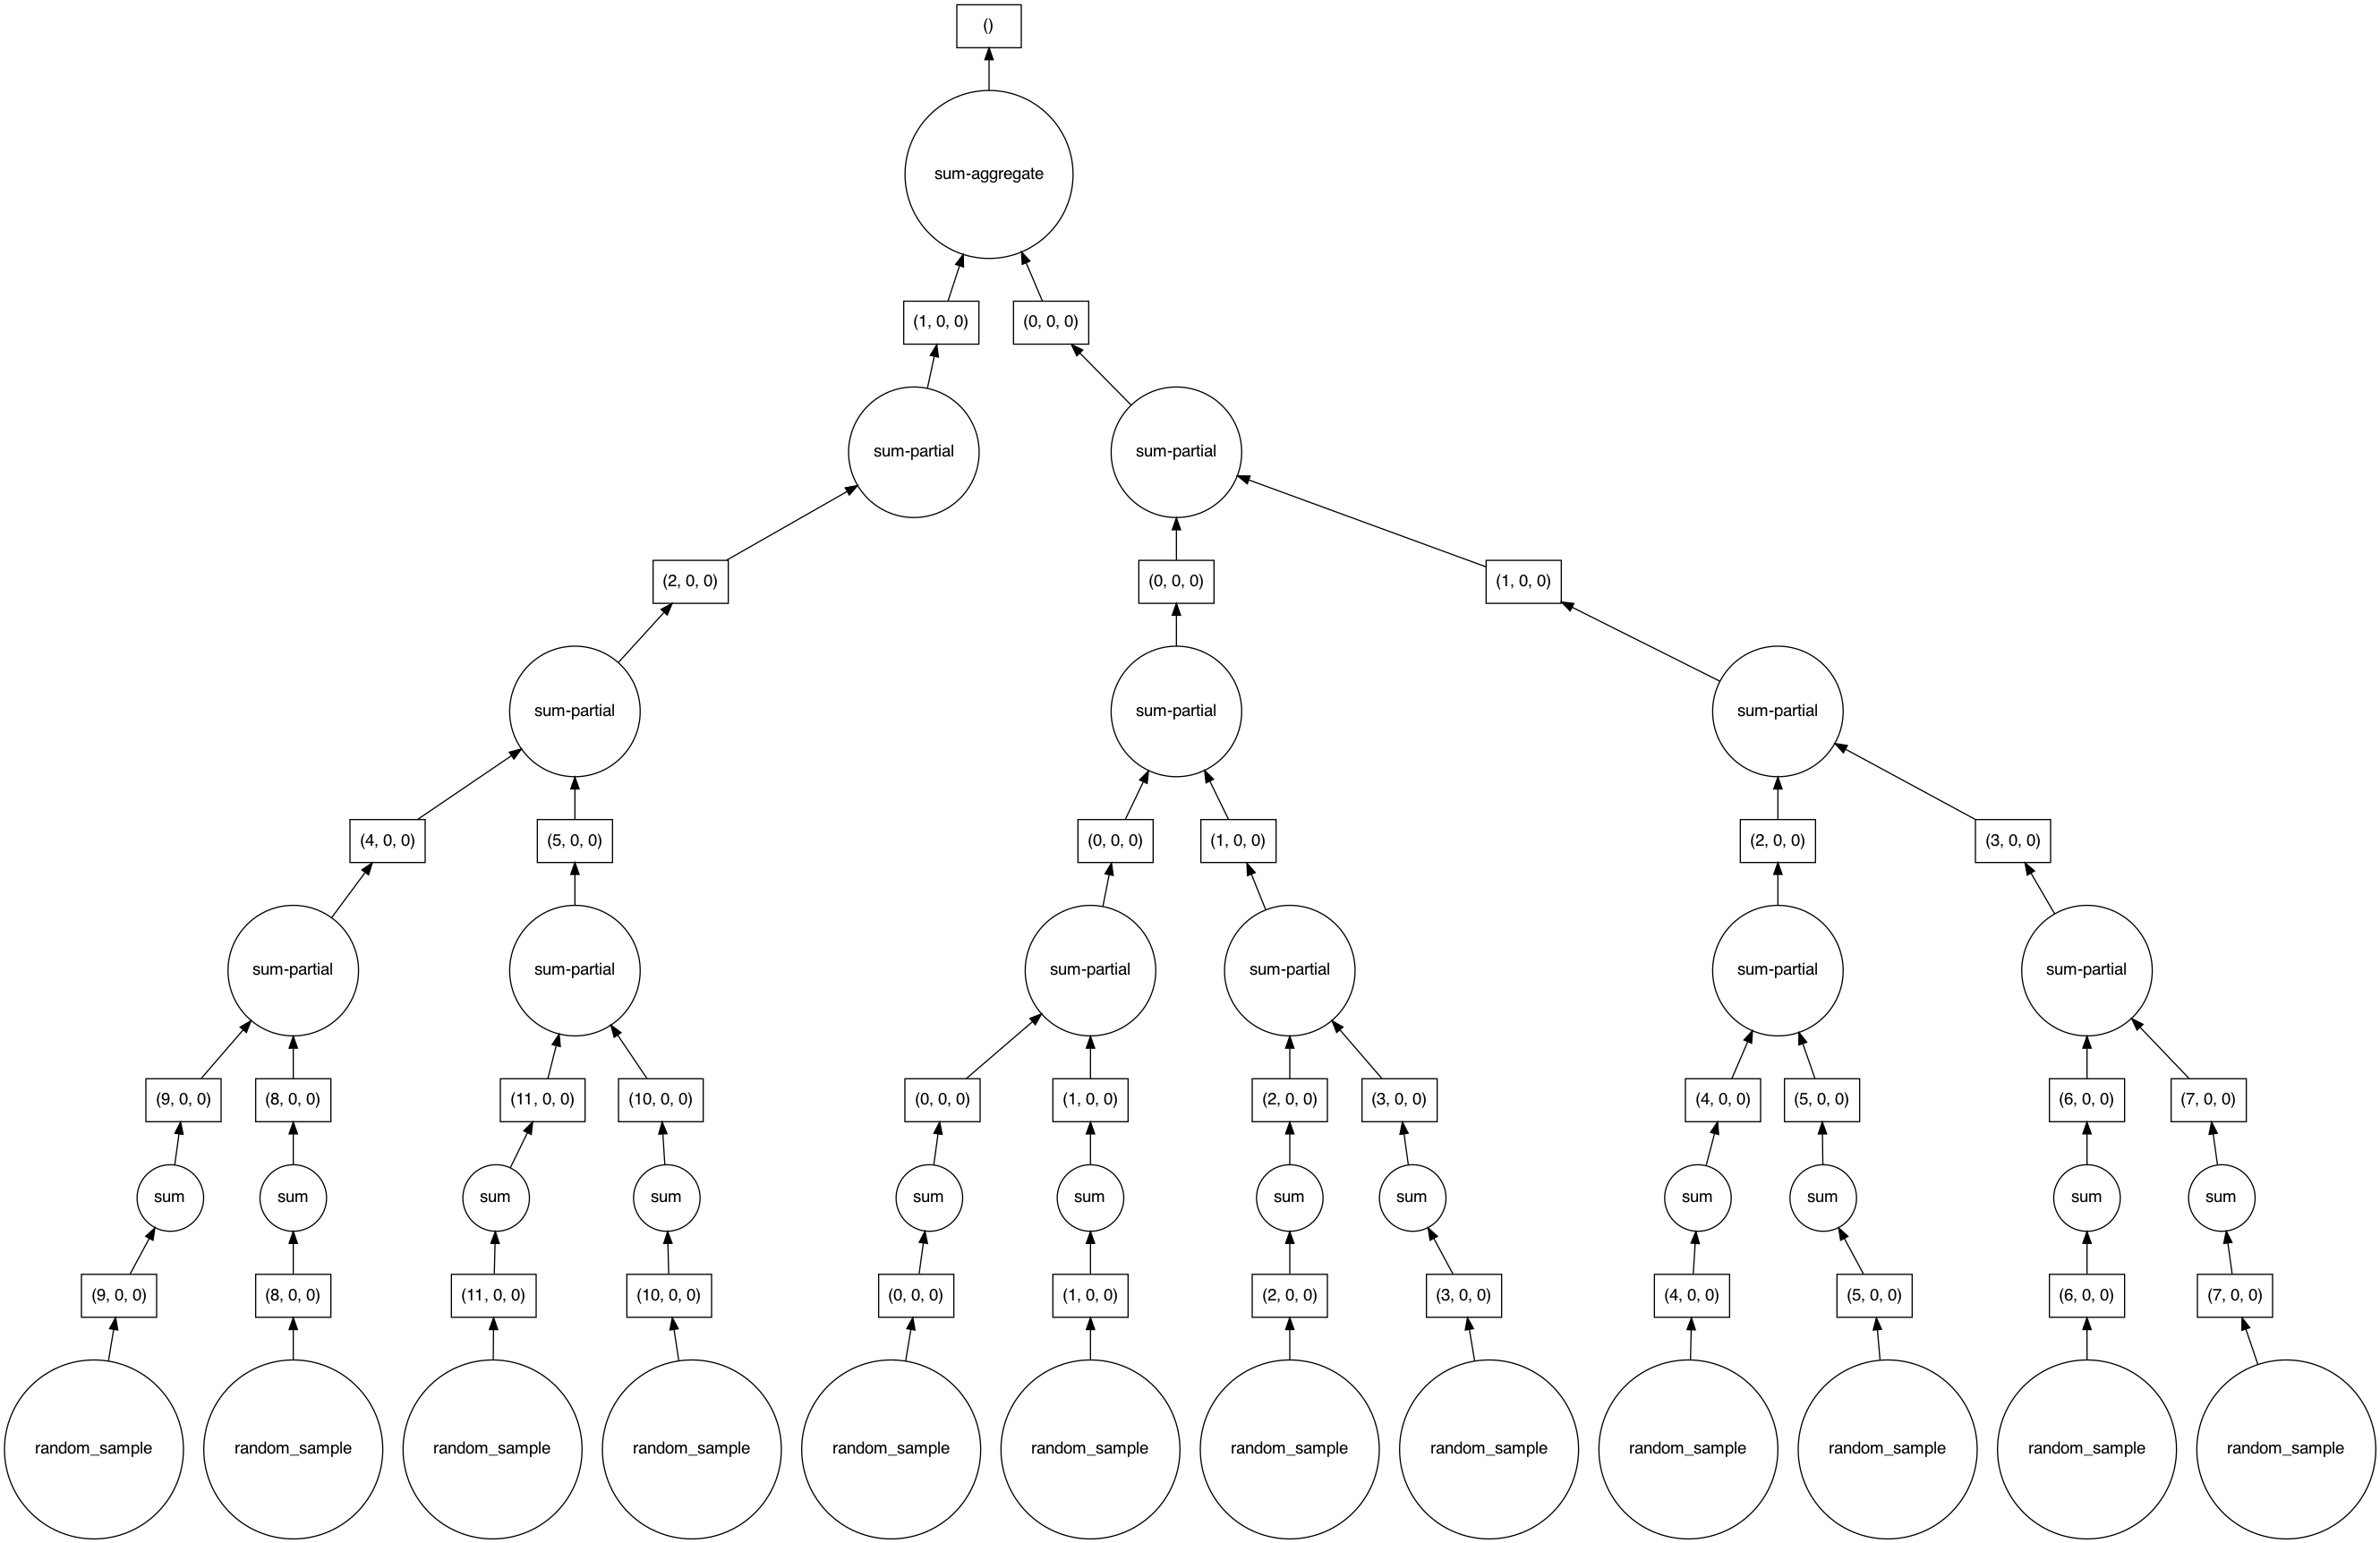

In [11]:
da.random.random(shape, chunks=(50, 200, 400)).sum().visualize()

Here we see Dask's strategy for finding the sum. This simple example illustrates the beauty of Dask: it automatically designs an algorithm appropriate for custom operations with big data.

If we make our operation more complex, the graph gets more complex:

In [12]:
z = darr.dot(darr.T).mean(axis=0)[::2, :].std(axis=1)
z

dask.array<_sqrt, shape=(100, 600), dtype=float64, chunksize=(50, 300), chunktype=numpy.ndarray>

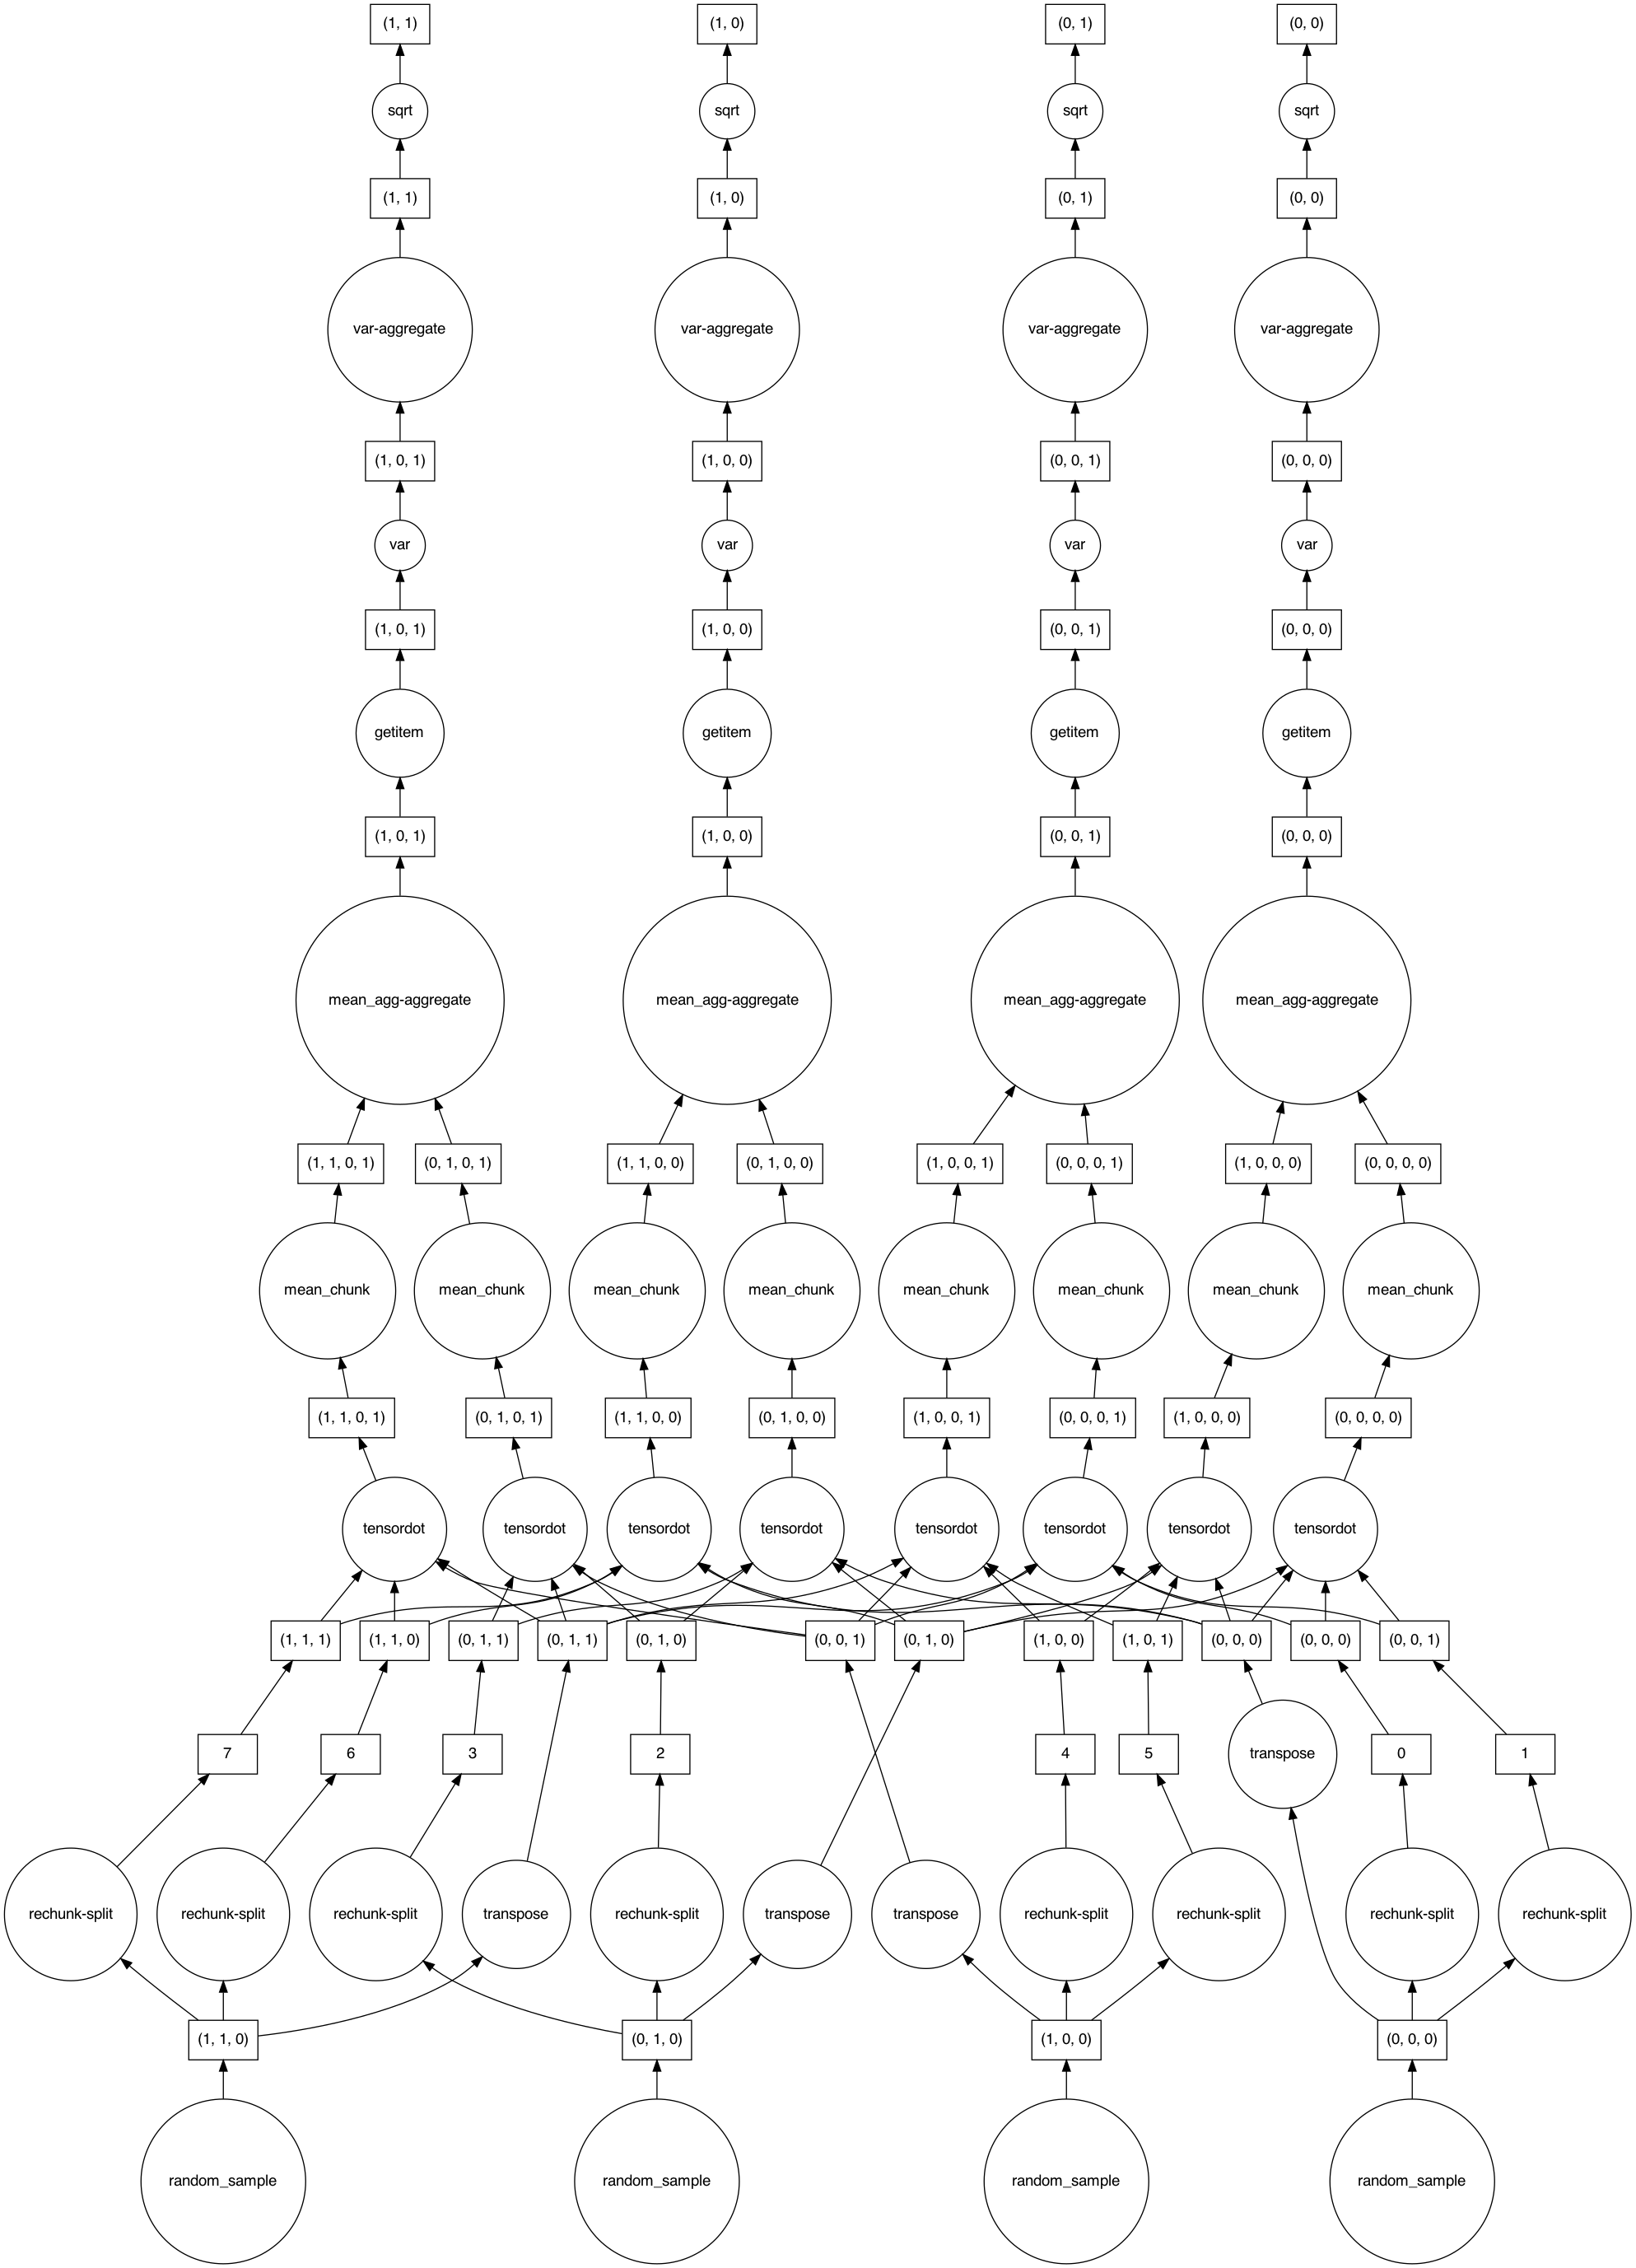

In [13]:
z.visualize()

### A Bigger Calculation

The examples above were toy examples; the data (180 MB) is probably not big enough to warrant the use of Dask.

We can make it a lot bigger! Let's create a new, big array

In [21]:
darr = da.random.random((4000, 100, 4000), chunks=(1000, 100, 500)).astype('float32')
darr

dask.array<astype, shape=(4000, 100, 4000), dtype=float32, chunksize=(1000, 100, 500), chunktype=numpy.ndarray>

This dataset is `~23 GB`, rather than 32 MB! This is probably close to or greater than the amount of available RAM than you have in your computer. Nevertheless, Dask has no problem working on it.

In [22]:
z = (darr + darr.T)[::2, :].mean(axis=2)

In [23]:
z.visualize()

In [26]:
%%time
z.compute()

CPU times: user 13.6 s, sys: 2.77 s, total: 16.4 s
Wall time: 1min 10s


array([[1.0034926 , 0.9963927 , 1.0102907 , ..., 1.0013229 , 1.0050374 ,
        1.0105656 ],
       [0.9887693 , 1.0051744 , 1.0011739 , ..., 1.0014411 , 0.9911464 ,
        1.0094068 ],
       [1.0016145 , 1.0031786 , 1.0019256 , ..., 0.9873556 , 0.9997713 ,
        0.9984558 ],
       ...,
       [0.99680686, 0.9947467 , 0.9871521 , ..., 1.0103115 , 0.99673647,
        1.0071186 ],
       [1.0059882 , 0.99043256, 0.992927  , ..., 1.0036316 , 1.0017059 ,
        0.99981654],
       [1.0085161 , 0.9859296 , 1.0071744 , ..., 0.99341214, 1.0147603 ,
        1.0051273 ]], dtype=float32)

In [27]:
cluster.close()
client.close()

---

## Summary

Dask Array does not implement the entire numpy interface.  Users expecting this
will be disappointed.  Notably Dask Array has the following failings:

1.  Dask does not implement all of ``np.linalg``.  This has been done by a
    number of excellent BLAS/LAPACK implementations and is the focus of
    numerous ongoing academic research projects.
2.  Dask Array does not support some operations where the resulting shape
    depends on the values of the array. For those that it does support
    (for example, masking one Dask Array with another boolean mask),
    the chunk sizes will be unknown, which may cause issues with other
    operations that need to know the chunk sizes.
3.  Dask Array does not attempt operations like ``sort`` which are notoriously
    difficult to do in parallel and are of somewhat diminished value on very
    large data (you rarely actually need a full sort).
    Often we include parallel-friendly alternatives like ``topk``.
4.  Dask development is driven by immediate need, and so many lesser used
    functions, like ``np.sometrue`` have not been implemented purely out of
    laziness.  These would make excellent community contributions.

## Learn More

Visit the [Array documentation](https://docs.dask.org/en/latest/array.html). In particular, this [array screencast](https://youtu.be/9h_61hXCDuI) will reinforce the concepts you learned here.



ERROR! Session/line number was not unique in database. History logging moved to new session 499


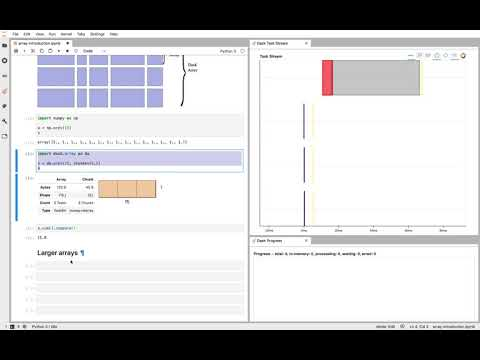

In [18]:
from IPython.display import YouTubeVideo

YouTubeVideo(id="9h_61hXCDuI", width=600, height=300)

## Resources and references

* Reference
    *  [Dask Docs](https://dask.org/)
    *  [Dask Examples](https://examples.dask.org/)
    *  [Dask Code](https://github.com/dask/dask/)
    *  [Dask Blog](https://blog.dask.org/)
    
    *  [Xarray Docs](https://xarray.pydata.org/)
  
*  Ask for help
    *   [`dask`](http://stackoverflow.com/questions/tagged/dask) tag on Stack Overflow, for usage questions
    *   [github discussions: dask](https://github.com/dask/dask/discussions) for general, non-bug, discussion, and usage questions
    *   [github issues: dask](https://github.com/dask/dask/issues/new) for bug reports and feature requests
     *   [github discussions: xarray](https://github.com/pydata/xarray/discussions) for general, non-bug, discussion, and usage questions
    *   [github issues: xarray](https://github.com/pydata/xarray/issues/new) for bug reports and feature requests
    
* Pieces of this notebook are adapted from the following sources
  * https://github.com/dask/dask-tutorial/blob/main/03_array.ipynb
  * https://github.com/xarray-contrib/xarray-tutorial/blob/master/scipy-tutorial/06_xarray_and_dask.ipynb